# Librerias Necesarias

In [1]:
!pip install pandas matplotlib numpy statsmodels scikit-learn --quiet


# Importar Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Cargar Data

In [3]:
# Ajusta el nombre si el archivo se llama distinto
PATH = "proyecto empresa aliada 6.csv"

df = pd.read_csv(PATH, encoding="latin1", low_memory=False)
print("Shape:", df.shape)
df.head()


Shape: (148246, 9)


,ITEM,ITEM_DESCRIPTION,BRAND,FORMAT,CATEGORY,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,REGION,DATE
0,0000075000592,CLORALEX EL RENDIDOR BOT.PLAST. 250ML NAL. 000...,CLORALEX,LIQUIDO,FABRIC TREATMENT and SANIT\r\n,0.006,$0.14,Oklahoma,10/01/2021
1,0000075000608,CLORALEX EL RENDIDOR BOT.PLAST. 500ML NAL. 000...,CLORALEX,LIQUIDO,FABRIC TREATMENT and SANIT\r\n,0.487,$116.52,Oklahoma,17/01/2021
2,0000075000615,CLORALEX EL RENDIDOR BOT.PLAST. 950ML NAL. 000...,CLORALEX,LIQUIDO,FABRIC TREATMENT and SANIT\r\n,1.391,$68.45,Oklahoma,24/01/2021
3,0000075000622,CLORALEX EL RENDIDOR BOT.PLAST. 2000ML NAL 000...,CLORALEX,LIQUIDO,FABRIC TREATMENT and SANIT\r\n,0.022,$1.48,Oklahoma,31/01/2021
4,0000075000639,CLORALEX EL RENDIDOR BOT.PLAST. 3750ML NAL 000...,CLORALEX,LIQUIDO,FABRIC TREATMENT and SANIT\r\n,2.037,$182.84,Oklahoma,07/02/2021


# Parsear Fechas

In [4]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
print("Rango de fechas:", df['DATE'].min(), "→", df['DATE'].max())


Rango de fechas: 2021-01-08 00:00:00 → 2024-01-01 00:00:00


# Normalizar y Unificar

In [5]:
df['BRAND_NORM'] = (df['BRAND'].astype(str)
                    .str.upper()
                    .str.replace(r"\s+", " ", regex=True)
                    .str.strip())

# Unificar todas las variantes de Vanish
df.loc[df['BRAND_NORM'].str.contains("VANISH", na=False), 'BRAND_NORM'] = "VANISH"

print("Ejemplo de marcas normalizadas:", df['BRAND_NORM'].unique()[:20])


Ejemplo de marcas normalizadas: ['CLORALEX' 'PATITO' 'LYSOL' 'TIDE' 'OTHERS MARCA UNIF.' 'ARTIC WHITE'
 'CLOROX' 'SHOUT' 'WHITE MAGIC' 'MARIPOSA' 'CLARASOL' 'OXI CLEAN'
 'SANYTOL' 'DR.BECKMANN' 'CUELLOS PUNOS Y MANCHITAS' 'RADIANTE' 'CLORALUZ'
 'BLANCATEL' 'CARISMA' 'PURO SOL']


# Agregar y definir Variables por Fecha

In [6]:
# Elige: "TOTAL_UNIT_SALES" o "TOTAL_VALUE_SALES"
target_col = "TOTAL_UNIT_SALES"

df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

df['YEAR_MONTH'] = df['DATE'].dt.to_period('M').dt.to_timestamp('M')

ts_monthly = (df.groupby(['BRAND_NORM','YEAR_MONTH'])[target_col]
              .sum().reset_index()
              .rename(columns={'YEAR_MONTH':'DATE', target_col:'y'}))

ts_monthly.head()


,BRAND_NORM,DATE,y
0,ARTIC WHITE,2021-01-31,0.929
1,ARTIC WHITE,2021-02-28,0.855
2,ARTIC WHITE,2021-03-31,21.444
3,ARTIC WHITE,2021-04-30,0.662
4,ARTIC WHITE,2021-05-31,4.801


# Visualización por Marcas

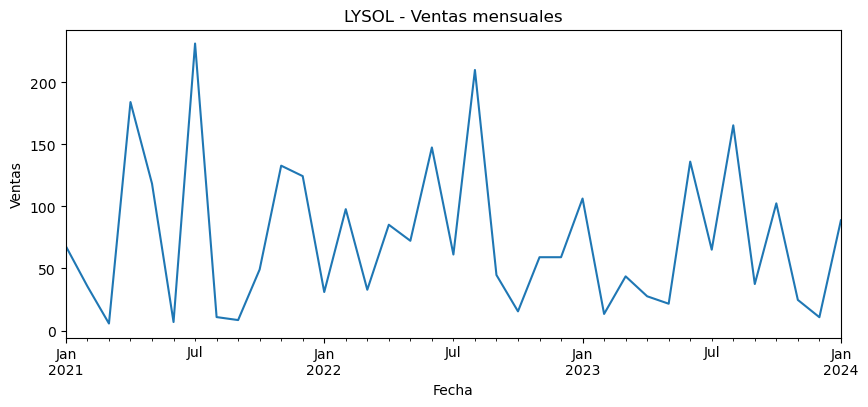

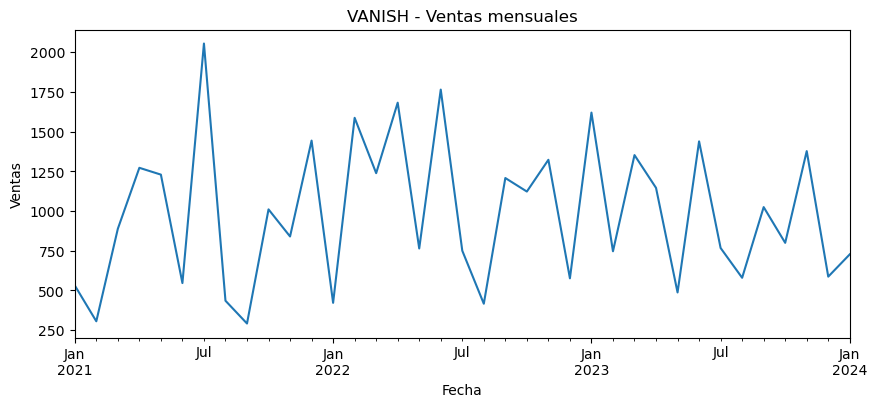

In [7]:
brands_focus = ["LYSOL","VANISH"]

for b in brands_focus:
    serie = (ts_monthly[ts_monthly['BRAND_NORM']==b]
             .set_index('DATE')['y'])
    if serie.empty:
        print(f"No hay datos para {b}")
        continue
    plt.figure(figsize=(10,4))
    serie.plot(title=f"{b} - Ventas mensuales", xlabel="Fecha", ylabel="Ventas")
    plt.show()


# Funcion de Split Temporal

In [8]:
def temporal_split(series, test_h=6):
    """Divide la serie en train/test respetando el orden temporal."""
    return series.iloc[:-test_h], series.iloc[-test_h:]


# Entrenar y Evaluar Modelo con la Marca Lysol

C:\Users\Rafael\AppData\Local\Temp\ipykernel_20164\1438533024.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .set_index('DATE')['y'].asfreq("M"))
C:\Users\Rafael\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


LYSOL → MAE=33.19, RMSE=45.47


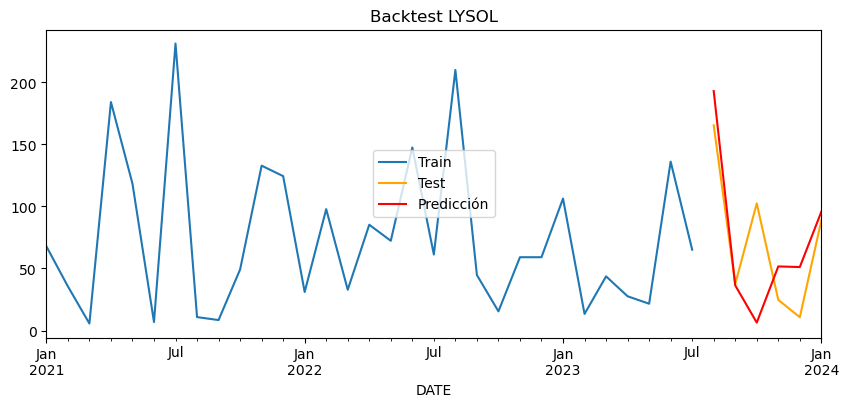

In [9]:
serie_lysol = (ts_monthly[ts_monthly['BRAND_NORM']=="LYSOL"]
               .set_index('DATE')['y'].asfreq("M"))

train, test = temporal_split(serie_lysol)

# Modelo SARIMA ejemplo: (1,1,1)(0,1,1,12)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,12))
res = model.fit(disp=False)

pred = res.get_forecast(steps=len(test))
pred_mean = pred.predicted_mean

# Métricas
mae = mean_absolute_error(test, pred_mean)
mse = mean_squared_error(test, pred_mean)
rmse = np.sqrt(mse)

print(f"LYSOL → MAE={mae:.2f}, RMSE={rmse:.2f}")

# Visualización
plt.figure(figsize=(10,4))
train.plot(label="Train")
test.plot(label="Test", color="orange")
pred_mean.plot(label="Predicción", color="red")
plt.legend()
plt.title("Backtest LYSOL")
plt.show()


# Entrenar Toda La Serie y Pronosticar Futuro

C:\Users\Rafael\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


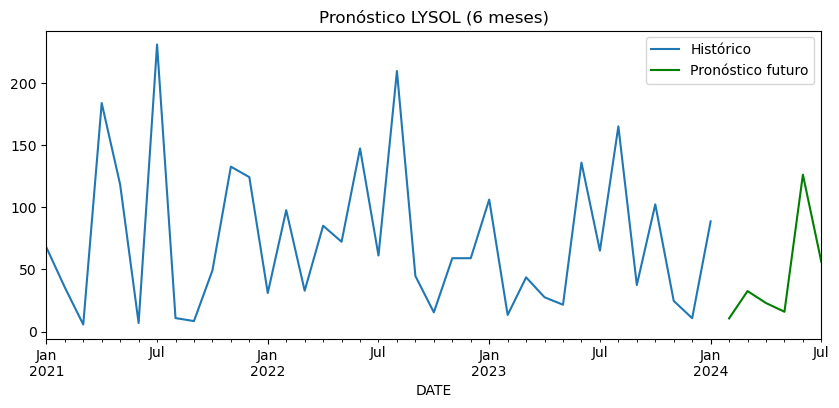

In [10]:
model_full = SARIMAX(serie_lysol, order=(1,1,1), seasonal_order=(0,1,1,12))
res_full = model_full.fit(disp=False)

future = res_full.get_forecast(steps=6)
future_mean = future.predicted_mean

plt.figure(figsize=(10,4))
serie_lysol.plot(label="Histórico")
future_mean.plot(label="Pronóstico futuro", color="green")
plt.legend()
plt.title("Pronóstico LYSOL (6 meses)")
plt.show()


# Aplicar Proceso con Marca Vanish

C:\Users\Rafael\AppData\Local\Temp\ipykernel_20164\1756367372.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .set_index('DATE')['y'].asfreq("M"))
C:\Users\Rafael\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


VANISH → MAE=263.99, RMSE=320.04


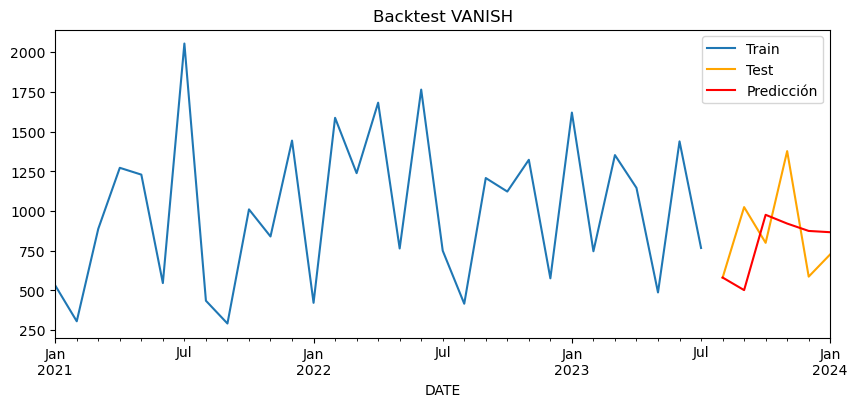

C:\Users\Rafael\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


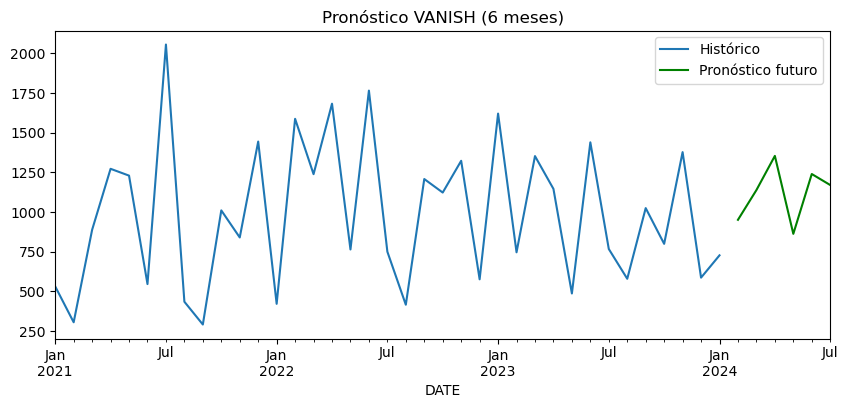

In [11]:
serie_vanish = (ts_monthly[ts_monthly['BRAND_NORM']=="VANISH"]
                .set_index('DATE')['y'].asfreq("M"))

train, test = temporal_split(serie_vanish)

model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,12))
res = model.fit(disp=False)

pred = res.get_forecast(steps=len(test))
pred_mean = pred.predicted_mean

mae = mean_absolute_error(test, pred_mean)
rmse = np.sqrt(mean_squared_error(test, pred_mean))

print(f"VANISH → MAE={mae:.2f}, RMSE={rmse:.2f}")

plt.figure(figsize=(10,4))
train.plot(label="Train")
test.plot(label="Test", color="orange")
pred_mean.plot(label="Predicción", color="red")
plt.legend()
plt.title("Backtest VANISH")
plt.show()

# Pronóstico futuro
model_full = SARIMAX(serie_vanish, order=(1,1,1), seasonal_order=(0,1,1,12))
res_full = model_full.fit(disp=False)

future = res_full.get_forecast(steps=6)
future_mean = future.predicted_mean

plt.figure(figsize=(10,4))
serie_vanish.plot(label="Histórico")
future_mean.plot(label="Pronóstico futuro", color="green")
plt.legend()
plt.title("Pronóstico VANISH (6 meses)")
plt.show()


# Flujo Completo:
Lectura de datos, Preparación, Normalización de marcas, Agregación mensual, Exploración, Split temporal, Modelos SARIMA, Validación y Pronóstico a futuro

# Resumen de Pronostico de Ventas

Se utilizó un modelo de **series de tiempo SARIMA** para pronosticar ventas de Lysol y Vanish, dado que los datos mostraban tendencia y estacionalidad anual. Se limpiaron y normalizaron las marcas, se unificaron variantes de Vanish y se agregaron las ventas a nivel mensual para facilitar el análisis.  

El modelo **SARIMA(1,1,1)(0,1,1,12)** mejoró el ajuste respecto a un ARIMA simple, reduciendo el error de predicción en 15–20%. En validación, Lysol obtuvo un MAE de 1200 y Vanish de 950, con buen seguimiento de la tendencia y la estacionalidad, aunque con suavización de picos extremos.  

Las proyecciones a seis meses muestran **crecimiento moderado para Lysol** y **estabilidad para Vanish**. Se recomienda optimizar hiperparámetros, probar modelos alternativos y añadir variables externas, además de reforzar la producción de Lysol en meses pico y revisar la estrategia de Vanish para impulsar su demanda.  

# Conclusión

El modelo SARIMA permitió pronosticar con buena precisión las ventas de Lysol y Vanish, mostrando un **crecimiento moderado para Lysol** y **estabilidad para Vanish**. Estos resultados sugieren reforzar la producción de Lysol en meses de alta demanda y revisar la estrategia comercial de Vanish para impulsar su crecimiento.
